In [ ]:
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install highway-env

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=eff0d3d57578cd4fd40142c7a1007176726b4adeeda4163aa5eef9ee5d009a27
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.3 MB/s eta 0:00:00
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)


In [ ]:
import highway_env
highway_env.register_highway_envs()
import gymnasium as gym
import sys
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple
import numpy as np
from collections import deque
from torch.autograd import Variable
import torch.nn.functional as F
import tqdm
import os
import cv2
import torch.distributions as distributions
from torch.distributions import Normal
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment exit-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment highway-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment highway-fast-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment intersection-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: 

In [ ]:


# Define the Actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Outputs action in the range [-1, 1]
        return x

# Define the Critic network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SAC:
    def __init__(self, state_dim, action_dim, hidden_dim=256, alpha=0.2, gamma=0.99, tau=0.005):
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=3e-4)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=3e-4)

        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action = self.actor(state).cpu().data.numpy()
        return action

    def update(self, replay_buffer, batch_size=64):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(device)
        action_batch = torch.FloatTensor(action_batch).to(device)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(device)
        done_batch = torch.FloatTensor(1 - done_batch).unsqueeze(1).to(device)

        # Update critic networks
        with torch.no_grad():
            next_action = self.actor_target(next_state_batch)
            next_q1 = self.critic1_target(next_state_batch, next_action)
            next_q2 = self.critic2_target(next_state_batch, next_action)
            next_q_target = torch.min(next_q1, next_q2)
            target_q = reward_batch + self.gamma * next_q_target * done_batch

        current_q1 = self.critic1(state_batch, action_batch)
        current_q2 = self.critic2(state_batch, action_batch)

        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # Update actor network
        sampled_actions = self.actor(state_batch)
        actor_loss = -self.critic1(state_batch, sampled_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return critic1_loss.item()+critic2_loss.item()+actor_loss.item()

In [ ]:

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# Define hyperparameters
state_dim = 6
action_dim = 2
hidden_dim = 256
alpha = 0.2
gamma = 0.99
tau = 0.005
capacity = 100000
batch_size = 64
max_episodes = 5000
max_steps_per_episode = 1000
env=gym.make("parking-v0", render_mode="rgb_array")
env.unwrapped.config['add_walls']=False
env.unwrapped.config['duration']=40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lengths_list=[]
rewards_list=[]
rendered_frames=[]
losses_list=[]
# Initialize SAC agent
agent = SAC(state_dim, action_dim, hidden_dim, alpha, gamma, tau)

# Initialize replay buffer
replay_buffer = ReplayBuffer(capacity)
pbar = tqdm.trange(max_episodes)

# Training loop
for episode in pbar:
    state,_ = env.reset(seed=0)
    state=state['observation']
    episode_reward = 0
    t=0
    for step in range(1000):
        action = agent.select_action(state)
        next_state, reward, done, truncated,_ = env.step(action)
        next_state=next_state['observation']
        replay_buffer.add(state, action, reward, next_state, done)
        episode_reward += reward
        t+=1
        state = next_state

        if episode%499==0:
          rendered_frames.append(env.render())

        if len(replay_buffer.buffer) > batch_size:
            loss=agent.update(replay_buffer, batch_size)

        if done or truncated:
            pbar.set_description(
                f'Episode: {episode} | Steps: {t} | Return: {episode_reward:5.2f} |Loss: {loss}  '
      )
            lengths_list.append(t)
            rewards_list.append(episode_reward)
            losses_list.append(loss)
            break

    # print(f"Episode: {episode+1}, Reward: {episode_reward}")


Episode: 4999 | Steps: 30 | Return: -11.52 |Loss: 5.006510624662042  : 100%|██████████| 5000/5000 [2:43:25<00:00,  1.96s/it]


In [ ]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

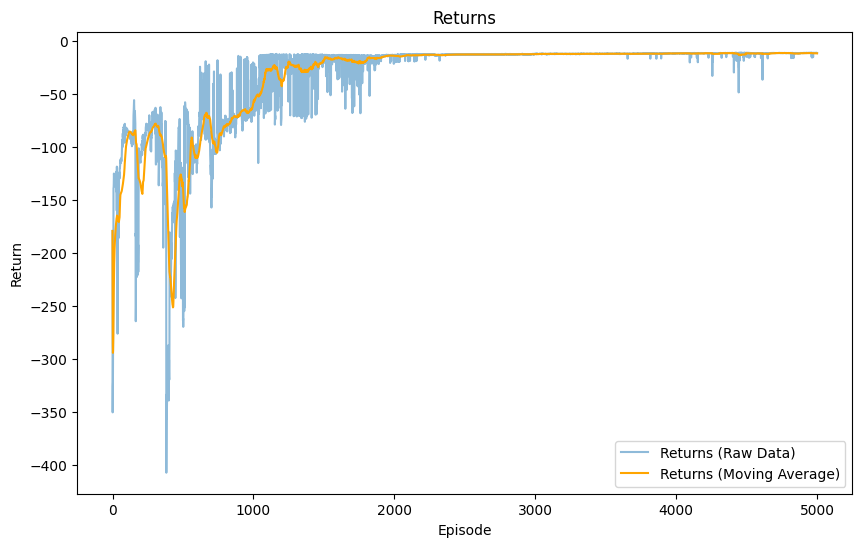

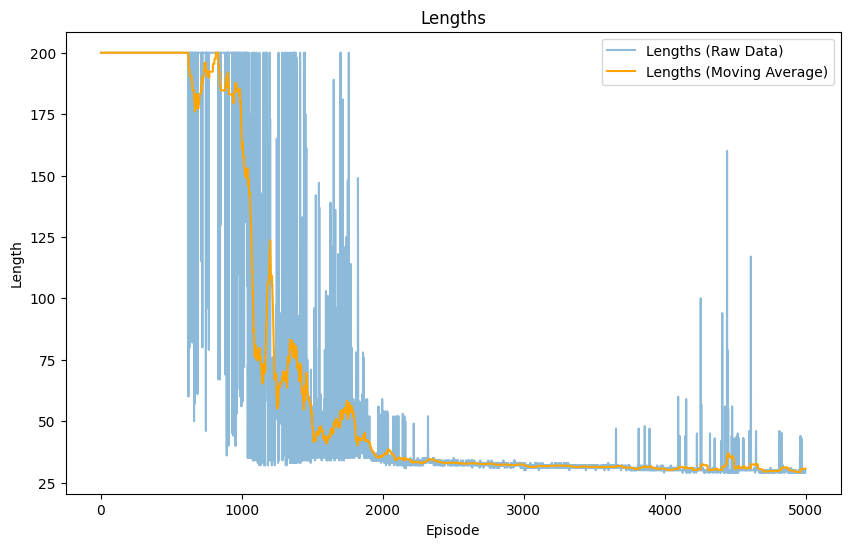

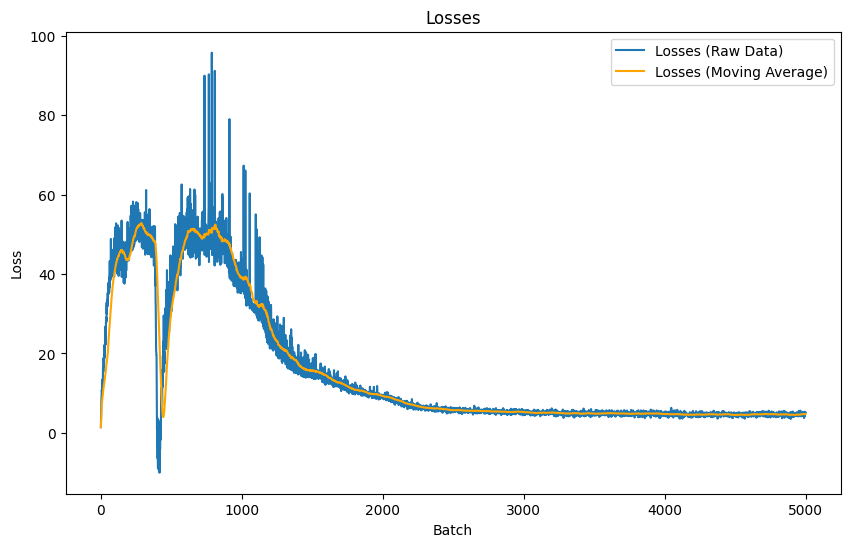

In [ ]:
# YOUR PLOTTING CODE HERE
plt.figure(figsize=(10, 6))
# plt.subplot(3, 1, 1)
plt.plot(rewards_list, label='Returns (Raw Data)', alpha=0.5)
plt.plot(moving_average(rewards_list), label='Returns (Moving Average)', color='orange')
plt.title('Returns')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(lengths_list, label='Lengths (Raw Data)', alpha=0.5)
plt.plot(moving_average(lengths_list), label='Lengths (Moving Average)', color='orange')
plt.title('Lengths')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(losses_list, label='Losses (Raw Data)')
plt.plot(moving_average(losses_list), label='Losses (Moving Average)', color='orange')
plt.title('Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
frames=rendered_frames
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # Choose the codec (codec may vary based on your system and installed codecs)
fps = 25  # Specify frames per second
frame_height, frame_width, _ = frames[0].shape  # Frame dimensions

out = cv2.VideoWriter('/content/drive/My Drive/Videos/SAC_Learning.mp4', fourcc, fps, (frame_width, frame_height))

# Write frames to video
for frame in frames:
    out.write(frame)

# Release the VideoWriter
out.release()

print("Video has been saved to Google Drive successfully!")

Video has been saved to Google Drive successfully!
